# 模拟细菌菌落在平面上的生长和繁殖：圆形菌落
该协议复现了主要文本中的模拟程序，该程序通过生长细胞间的机械推动来模拟菌落扩张现象。所实现模型的一个特点是，其菌落形态会随着密集堆积参数的不同值发生转变。在这个协议中，我们将选择一组参数，使得模拟得到的是圆形菌落形态。而在“分支菌落”场景中，我们将选取能够导致菌落呈现分支状生长的参数。

此外，我们还将展示如何从单一种营养物的摄取构建一个简单的代谢模型，并只包含一个与生物量增长相关的反应。

值得注意的是，尽管在论文中使用的布局较大，但在本操作中我们会将其设计得小很多，这样可以大大加快运行速度。

In [1]:
import cobra
import cobra.io # for the ijo1366 model
import sys
import numpy as np
import cometspy as c

首先，让我们使用cobrapy的功能制作一个“toy”模型。它直接将细胞外碳转化为生物质。

In [2]:
carbon = cobra.Metabolite("carbon",
                           compartment = "e")
carbon_exch = cobra.Reaction("Carbon_exch",
                            lower_bound = -1.,
                            upper_bound = 1000.)
carbon_exch.add_metabolites({carbon: -1.})
Biomass = cobra.Reaction("Biomass",
                        lower_bound = 0.,
                        upper_bound = 1000.)
Biomass.add_metabolites({carbon: -1.})
toy = cobra.Model("toy")
toy.add_reactions([carbon_exch, Biomass])
#toy.add_reactions([carbon_exch, carbon_transport, Biomass])
toy.objective = "Biomass"
toy.repair()

我们可以通过在 cobrapy 中执行 FBA 来测试模型是否运行。它产生的生物量应该与carbon_exch的下限一样多。



In [3]:
print(toy.medium)
print(toy.optimize().objective_value)

{'Carbon_exch': 1.0}
1.0


现在，我们将将其转换为COMETS模型，设置其初始生物量，并设置第一组对流参数。这些是用这个玩具模型获得圆形菌落所需的参数。请注意，对于这种形式的生物质传播，时间步长必须设置得非常低。

In [4]:
grid_size = 50

toy_comets = c.model(toy)
toy_comets.initial_pop = [int(grid_size / 2),int(grid_size / 2),1.0]
toy_comets.reactions.loc[toy_comets.reactions.EXCH, "LB"] = -1000
toy_comets.add_convection_parameters(packedDensity = 0.5,
                                    elasticModulus = 1.e-4,
                                    frictionConstant = 1.0,
                                    convDiffConstant = 0.0)
toy_comets.add_noise_variance_parameter(20.)

C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:623: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.smat = pd.concat([self.smat, cdf])
C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:636: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


我们确保COMETS模型不将生物质反应视为交换。



In [5]:
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass","EXCH"] = False
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass","EXCH_IND"] = 0
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass", "LB"] = 0

本次模拟的布局将在一个100x100网格上设立单一、居中的菌落。碳源将会在整个区域内均匀分布。

In [6]:
ly = c.layout([toy_comets])
ly.grid = [grid_size, grid_size]
ly.set_specific_metabolite("carbon", 1.)

C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\layout.py:1361: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.media = pd.concat([self.media, new_row],


我们需要设置的主要参数是“biomassmotionstyle”，必须将其设置为“Convection 2D”。为了捕捉空间信息，除了记录总生物量外，我们还会记录个体生物量的变化。最后，我们还会调整一些其他参数。这些参数都被存储在一个名为all_params的字典中。

In [7]:
p = c.params()

p.set_param("biomassMotionStyle", "Convection 2D")
p.set_param("writeBiomassLog", True)
p.set_param("BiomassLogRate", 100)
p.set_param("maxCycles", 2000)
p.set_param("timeStep", 0.0005)
p.set_param("spaceWidth", 1)
p.set_param("maxSpaceBiomass", 10)
p.set_param("minSpaceBiomass", 0.25e-10)
p.set_param("allowCellOverlap", True)
p.set_param("growthDiffRate", 0)
p.set_param("flowDiffRate", 3e-9)
p.set_param("exchangestyle", "Monod Style")
p.set_param("defaultKm", 0.01)
p.set_param("defaultHill", 1)
p.set_param("defaultVmax", 100)

现在我们制作一个模拟对象并运行它。这可能需要一段时间.

In [8]:
sim = c.comets(ly, p)
sim.run() # set delete_files = False to maintain all comets-generated files


Running COMETS simulation ...
Done!


现在让我们绘制结果图。我们使用辅助脚本“get_biomass_image”，它需要模型的名称和时间步长。然后我们使用 matplotlib 来显示它。

C:\Users\99374\AppData\Local\Temp\ipykernel_11556\2069169666.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = matplotlib.cm.get_cmap("copper")


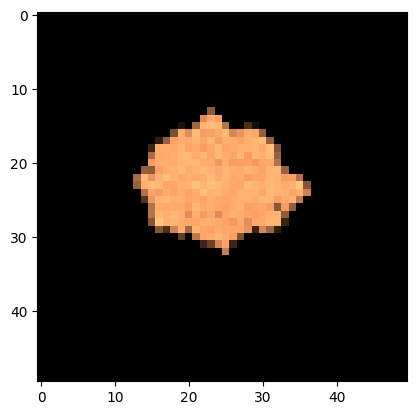

In [9]:
im = sim.get_biomass_image('toy', 2000)
from matplotlib import pyplot as plt
import matplotlib.colors, matplotlib.cm
my_cmap = matplotlib.cm.get_cmap("copper")
my_cmap.set_bad((0,0,0))
plt.imshow(im, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)  

我们可以在一个简单的循环中平铺时间序列。

In [10]:
big_image = np.zeros((grid_size * 4, grid_size * 5))
im_cycles = np.arange(p.all_params["BiomassLogRate"], p.all_params["maxCycles"] + p.all_params["BiomassLogRate"],
                      p.all_params["BiomassLogRate"])
for i, cycle in enumerate(im_cycles):
    big_image[(grid_size * int(i / 5)):(grid_size + grid_size * int(i / 5)),(grid_size * (i % 5)):(grid_size + grid_size * (i % 5))] = sim.get_biomass_image("toy", cycle)

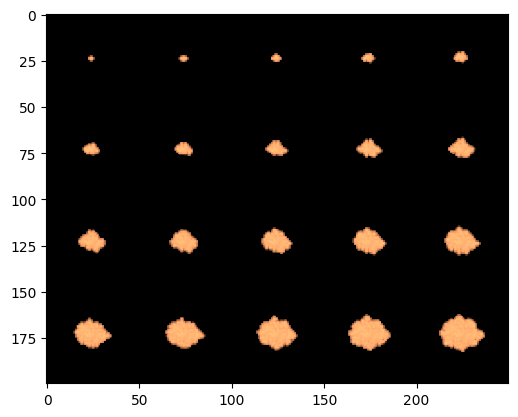

In [11]:
plt.imshow(big_image, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)